<a href="https://colab.research.google.com/github/NikV-JS/Reddit-Flair-Detector/blob/master/Notebooks/Reddit_Flair_Detector(Part_3).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook deals with the training of Deep Learning model for Reddit Flair Prediction and analysis of the classification results.

In [0]:
# Installing the required modules
!pip install -q tensorflow_gpu>=2.0 pandas ktrain 

In [0]:
# Importing necessary modules
import tensorflow as tf
print(tf.__version__)

2.1.0


In [0]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [0]:
import pandas as pd
import numpy as np

In [0]:
# Loading Train, Validation, and Test Data as Pandas DataFrame
Train_data = pd.read_csv('/content/Train_Data.csv')
Val_data = pd.read_csv('/content/Val_Data.csv')
Test_data = pd.read_csv('/content/Test_Data.csv')

In [0]:
# Print the 12 Flair Categories
flairs = list(set(Train_data['flair']))
flairs

['Food',
 'AskIndia',
 'Politics',
 'Non-Political',
 'Scheduled',
 'Policy/Economy',
 'CAA-NRC-NPR',
 'Science/Technology',
 'Business/Finance',
 'Photography',
 'Coronavirus',
 'Sports']

In [0]:
# Print size of training, validation and testing set
print('size of training set: %s' % (len(Train_data['Text'])))
print('size of validation set: %s' % (len(Val_data['Text'])))
print('size of testing set: %s' % (len(Test_data['Text'])))

size of training set: 3600
size of validation set: 1200
size of testing set: 1200


In [0]:
# Splitting the datasets into input and target labels for deep learning model
x_train = Train_data['Text']
y_train = Train_data['flair']
x_val = Val_data['Text']
y_val = Val_data['flair']
x_test = Test_data['Text']
y_test = Test_data['flair']

The Deep Learning (DL) Model I chose for the task of Reddit flair prediction is XLNet introduced by Google Brain and CMU. To understand the intuition behind choosing XLNet let's dive into some Natural Language Processing (NLP) history. Reddit Flair Prediction comes under the domain of Text Classification as we are trying to classify a collection of words under a post. The generic approach towards text classification 3 years back was to use Machine Learning (ML) Algorithms such as Logistic Regression, Random Forest. For these methods, the general approach was to first pre-process the data to remove stopwords and punctuations and then use word to vector embeddings so that they can apply the ML algorithm. Through NLP studies it was quite evident that stopwords and punctuations tend to contain useful information for the model to percieve but in general the frequency of stopwords is very high in text thereby increasing the sequence length. As the sequence length increases the performance of the standard ML algorithms decreases. 

So as Deep Learning Models improved and started to be applied to NLP, Google introduced transformers (attention based encoder-decoder) for NLP applications. In 2018, a wide range of Language Models were introduced with the main focus being on Google's BERT. Language Models were based on Deep Learning Models and they overcame the drawbacks of classic ML algorithms. Language Models had a large potential for application in various fields of NLP. Language Models application was based on transfer learning. For Deep Learning models the size of the dataset plays an important role in model overfitting and model generalization capability. Language Models have two phases that is pretrain phase and finetune phase. In the pretrain phase these Langauge Models are trained on large corpuses of text thereby allowing the model to gain contextual information of english language. The pretrain phase is where the XLNet (based on Transformer-XL) differs from BERT. The XLNet model uses Permutation Langauge Modeling (PLM) which enables it to have greater generalization capability and language understanding above BERT. This feature of XLNet enables it to outperform BERT in text classification. In finetune phase Language Models require small amount of data in application domain to achieve great performance. So using transfer learning with XLNet on our dataset enables for a great classification ability even with a small dataset. Another advantage of Langauge Models is that they use tokenization as pre-processing for data thereby preserving the information in stopwords and punctuations leading to better langauge understanding. These factors compelled me towards using XLNet for Reddit Flair Detection.

Google Brain and CMU have open sourced the pre-trained XLNet model for application in different domains. The Hugging Face Transformers python package contains most of the pre-trained Language Models. In Pytorch, FASTAI enables us to deploy langauge models easily. For this project I decided to use Tensorflow 2.1.0 . For training (finetuning) and validation of pretrained XLNet model  I used Ktrain , a lightweight wrapper for keras, which contains the pretrained Language Models from Hugging Face Transformers package. Firstly, Ktrain tokenizes (pre-processes) the data into the required format of the language model, here XLNet. XLNet is of two sizes. Here the XLNet Base version (smaller one) is used. Then accordingly a Keras model is created with pre-loaded weights. The following code is the procedure used to train XLNet for Reddit Flair Detection.








In [0]:
# Import ktrain module, preprocess the training and validation data
# and initialize XLNet model
import ktrain
from ktrain import text
MODEL_NAME = 'xlnet-base-cased'
t = text.Transformer(MODEL_NAME, maxlen=500, class_names=flairs)
train = t.preprocess_train(x_train, y_train)
val = t.preprocess_test(x_val, y_val)
model = t.get_classifier()
learner = ktrain.get_learner(model, train_data=train, val_data=val, batch_size=6)


preprocessing train...
language: en
train sequence lengths:
	mean : 63
	95percentile : 237
	99percentile : 951


/usr/local/lib/python3.6/dist-packages/ktrain/text/preprocessor.py:478: UserWarning: class_names argument was ignored, as they were extracted from string labels in dataset
  if self.get_classes(): warnings.warn('class_names argument was ignored, as they were extracted from string labels in dataset')


preprocessing test...
language: en
test sequence lengths:
	mean : 60
	95percentile : 296
	99percentile : 850


Before the training of the model is initialized, it is a good practice to find out the optimal learning rate for the model. Advanced APIs such as FASTAI and Ktrain enable us to find the optimal learning rate by simulating training for few epochs at different learning rates and plotting a loss vs learning rate graph. Through observation of the loss trend the optimal learning rate can be decided.

simulating training for different learning rates... this may take a few moments...
Train for 600 steps
Epoch 1/2
600/600 [==============================] - 1628s 3s/step - loss: 2.4240 - accuracy: 0.1564
Epoch 2/2
195/600 [========>.....................] - ETA: 18:18 - loss: 4.9945 - accuracy: 0.0983

done.


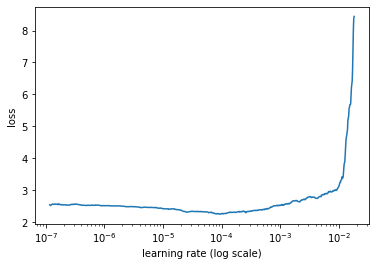

In [0]:
learner.lr_find(show_plot=True, max_epochs=2)

On observing the plot, it can be seen that 5e-5 is an optimal learning rate. Now we start training the model based on onecycle policy initially for 4 epochs to see if there is improvement of model performance as training continues.

In [0]:
learner.fit_onecycle(5e-5, 4)



begin training using onecycle policy with max lr of 5e-05...
Train for 600 steps, validate for 38 steps
Epoch 1/4
600/600 [==============================] - 1825s 3s/step - loss: 2.0359 - accuracy: 0.3211 - val_loss: 1.4058 - val_accuracy: 0.5642
Epoch 2/4
600/600 [==============================] - 1778s 3s/step - loss: 1.3207 - accuracy: 0.5775 - val_loss: 1.3196 - val_accuracy: 0.5800
Epoch 3/4
600/600 [==============================] - 1789s 3s/step - loss: 0.9221 - accuracy: 0.7139 - val_loss: 1.3131 - val_accuracy: 0.6183
Epoch 4/4
600/600 [==============================] - 1790s 3s/step - loss: 0.4841 - accuracy: 0.8606 - val_loss: 1.2643 - val_accuracy: 0.6575


It can be seen that the model is learning and the validation accuracy is improving.

In [0]:
learner.save_model('Model-1')

In [0]:
learner.load_model('/content/drive/My Drive/Model-XLNet', t)

Continue training the model for 5 more epochs based on onecycle policy.

In [0]:
learner.fit_onecycle(5e-5, 5, checkpoint_folder='/content/drive/My Drive/Model-XLNet')



begin training using onecycle policy with max lr of 5e-05...
Train for 600 steps, validate for 38 steps
Epoch 1/5
600/600 [==============================] - 642s 1s/step - loss: 0.3467 - accuracy: 0.8997 - val_loss: 1.4501 - val_accuracy: 0.6333
Epoch 2/5
600/600 [==============================] - 628s 1s/step - loss: 0.4173 - accuracy: 0.8742 - val_loss: 1.5659 - val_accuracy: 0.6183
Epoch 3/5
600/600 [==============================] - 612s 1s/step - loss: 0.4657 - accuracy: 0.8600 - val_loss: 1.6758 - val_accuracy: 0.5983
Epoch 4/5
600/600 [==============================] - 611s 1s/step - loss: 0.2539 - accuracy: 0.9281 - val_loss: 1.7356 - val_accuracy: 0.6283
Epoch 5/5
600/600 [==============================] - 611s 1s/step - loss: 0.1004 - accuracy: 0.9714 - val_loss: 1.7935 - val_accuracy: 0.6333


It can be observed that the validation accuracy is reaching a plateau. So now to finish the model training, the approach is to use early stopping and reducing learning rate on reaching a plateau. These features are inbuilt into the autofit function of Ktrain. Early stopping prevents the model from overfitting on the training dataset. 

In [0]:
learner.autofit(2e-5)

early_stopping automatically enabled at patience=5
reduce_on_plateau automatically enabled at patience=2


begin training using triangular learning rate policy with max lr of 2e-05...
Train for 600 steps, validate for 38 steps
Epoch 1/1024
600/600 [==============================] - 612s 1s/step - loss: 0.0662 - accuracy: 0.9842 - val_loss: 1.8815 - val_accuracy: 0.6425
Epoch 2/1024
600/600 [==============================] - 610s 1s/step - loss: 0.0550 - accuracy: 0.9856 - val_loss: 1.9893 - val_accuracy: 0.6358
Epoch 3/1024
599/600 [============================>.] - ETA: 0s - loss: 0.0686 - accuracy: 0.9786
Epoch 00003: Reducing Max LR on Plateau: new max lr will be 1e-05 (if not early_stopping).
600/600 [==============================] - 610s 1s/step - loss: 0.0685 - accuracy: 0.9786 - val_loss: 1.9771 - val_accuracy: 0.6358
Epoch 4/1024
600/600 [==============================] - 610s 1s/step - loss: 0.0404 - accuracy: 0.9875 - val_loss: 1.9841 - val_accuracy: 0.6425
Epoch 5/1024
599/

Now the model training has been successfully finished and XLNet model with Validation accuracy of 64.25 % has been obtained. Since the validation and test data set are of similar distribution, it is expected that the Test accuracy is also around 65 %. The following code is used to obtain precision, recall, f1-score for each flair category in the dataset. Also the confusion matrix is obtained and plotted for detailed analysis. 

In [0]:
cm_val = learner.validate(val_data=val, class_names=flairs)

                    precision    recall  f1-score   support

       CAA-NRC-NPR       0.62      0.67      0.64       148
    Policy/Economy       0.54      0.55      0.54        94
Science/Technology       0.91      0.88      0.89        24
          Politics       0.92      0.95      0.93        58
            Sports       0.74      0.79      0.76        98
          AskIndia       0.36      0.46      0.41       148
     Non-Political       0.86      0.72      0.78        92
       Coronavirus       0.44      0.49      0.46        98
       Photography       0.65      0.61      0.63       151
  Business/Finance       0.87      0.77      0.82       104
         Scheduled       0.58      0.48      0.52        94
              Food       0.93      0.75      0.83        91

          accuracy                           0.64      1200
         macro avg       0.70      0.68      0.69      1200
      weighted avg       0.66      0.64      0.65      1200



On observation of the F1-score for all the 12 flair categories it can be inferred that the XLNet model shows good performance on almost all flair categories with some hinderance in AskIndia and Coronavirus category. We can see that the model does exceptionally good in classifying flairs of category 'Science/Technology', 'Politics', 'Business/Finance'and 'Food'. We can also see that the model displays a good performance in 'Non-political', and 'Sports'.

Next step will be to plot the Confusion Matrix for the validation set for further analysis. A Confusion Matrix is a performance measurement for Machine Learning and also DL Methods. Confusion Matrix is widely used for describing performance of Classification models and it allows the visualization of performance of classifier. The confusion matrix shows the ways in which your classification model is confused when it makes predictions. It gives us insight not only into the mistakes being made by a classifier but more importantly the types of mistakes that are being made.

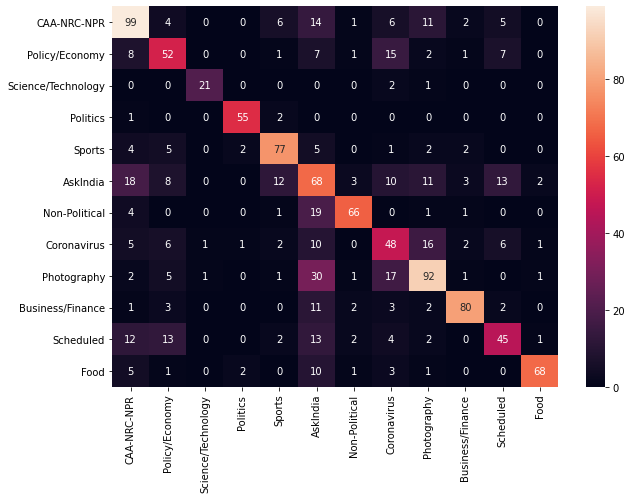

In [0]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(cm_val, index = [i for i in flairs],
                  columns = [i for i in flairs])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

In the confusion matrix the row index indicates predicted class and the column index indicates actual class. On analysis of the heatmap of confusion matrix, we can see that the XLNet model shows good performance across all 12 flairs as depicted by the diagonal of the confusion matrix. Alligning with the stastical report we can see that the model has almost no confusion in predicting flairs of category 'Science/Technology', 'Politics', 'Business/Finance', 'Food'. An unexpected trend that can be detected is that there is a confusion between Photography and Coronavirus thereby resulting in a square in those blocks in the heatmap. Relatively the model has shown a lower performance in Coronavirus due to possible intersection of domains in the posts. This is clearly evident on observing the Coronavirus row. Another detected confusion is between Photography and AskIndia where most AskIndia posts are detected as Photography. Also there seems to be slight confusion between Non-Political and AskIndia posts. We can also infer the reason for relatively low performance in AskIndia category through the Confusion Matrix. On observation of AskIndia column we can see that classification of AskIndia posts has confusion across most of the column thereby indicating intersecting domains or topics as a possible reason. In AskIndia posts this scenario is totally possible because they are questions based on various topics.

Thus, through this analysis we gain a good insight of Model performance as in where it works and where the performance might be hindered. Now the next step will be to verify the effectiveness of model by validating on test set and see if the same insights hold true. Also the test set will be an indicator of real world accuracy.

Next, the test data is preprocessed so that we can find out the test accuracy. Since the XLNet model has not been exposed to the test data prior to testing. The test accuracy can be an indicator of real world accuracy on the respective 12 flair categories.

In [0]:
test = t.preprocess_test(x_test, y_test)

preprocessing test...
language: en
test sequence lengths:
	mean : 65
	95percentile : 257
	99percentile : 907


In [0]:
# Validating model on Test data
cm_test = learner.validate(val_data=test, class_names=flairs)

                    precision    recall  f1-score   support

       CAA-NRC-NPR       0.68      0.73      0.71       147
    Policy/Economy       0.68      0.64      0.66       115
Science/Technology       0.92      0.96      0.94        25
          Politics       0.90      0.93      0.91        46
            Sports       0.68      0.73      0.70        95
          AskIndia       0.37      0.42      0.39       135
     Non-Political       0.85      0.73      0.79       101
       Coronavirus       0.55      0.61      0.58        94
       Photography       0.66      0.62      0.64       148
  Business/Finance       0.85      0.82      0.84       107
         Scheduled       0.58      0.45      0.51        98
              Food       0.77      0.80      0.78        89

          accuracy                           0.67      1200
         macro avg       0.71      0.70      0.70      1200
      weighted avg       0.67      0.67      0.67      1200



We can observe that the XLNet model has achieved a final test accuracy of 67 %. It displays great performance across all 12 flairs except AskIndia which is inline with the performance observed on validation dataset. Alligning with the validation performance, the model works exceptionally good on 'Science/Technology', 'Politics', 'Business/Finance', 'Food' and 'Non-Political'. We can see consistent performance in the model across both validation and test sets.

Next, the confusion marix is also plotted to see if the same trend can be observed.

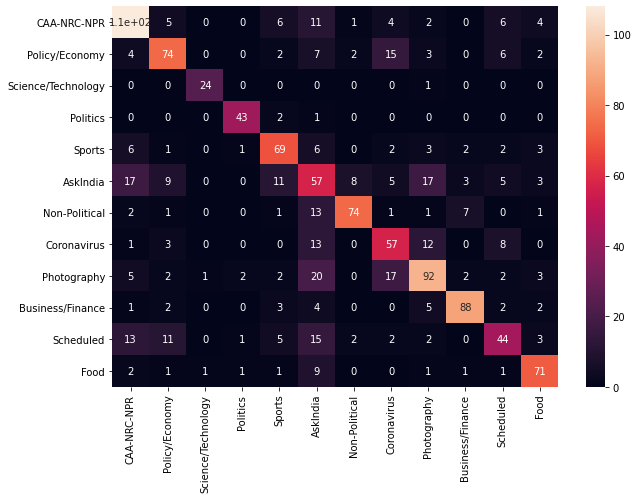

In [0]:
df_cm_test = pd.DataFrame(cm_test, index = [i for i in flairs],
                  columns = [i for i in flairs])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm_test, annot=True)

As expected, the same trend is visible in the heatmap of the confusion matrix on test set. Similar to the validation set a confusion can be detected between Coronovirus and Photography, AskIndia and Non-Political. Also the same AskIndia trend can be seen. AskIndia category has confusion spread across all the 12 flair categories indicating that major topic intersection might be the main reason and also the reason being that the questions are spread across various domains.

Finally, it can be concluded that the XLNet model has shown very good generalization capability in classifying the flairs. Even with a relatively small dataset we were able to obtain great results where only the slight confusion between Coronavirus and Photography seemed unreasonable, bearing in mind the Coronavirus flair was limited by the number of cases due to the Reddit limiations. Overall the model XLNet achieved good results and showed great potential in classifying flairs of Reddit Posts.

In [0]:
# Saving XLNet model along with weigths
learner.save_model('/content/drive/My Drive/Model-XLNet/model_XLNet')

In [0]:
# Loading XLNet model and weights
learner.load_model('/content/drive/My Drive/Models/model_XLNet', t)

To wrap things up, I wanted to conduct a small study to observe the Inference Capability and language understanding of the model and compare it with human approach. For this purpose Ktrain has very good explainable AI functions which help in understanding the reason behind the model's predictions. Explainable AI involves methods and techniques to help understand how an AI model reach particular conclusions. Active research is being pursued in explainable AI but there are some established practices to determine behaviour of model.

In [0]:
# Configuring Pandas options to display full content of columns in DataFrame
pd.set_option('display.max_colwidth', -1)

To understand the behaviour of the model, some interesting cases from the top losses in validation and test set are taken and studied.

In [0]:
learner.view_top_losses(n=10, preproc=t, val_data=val)

----------
id:506 | loss:10.53 | true:Policy/Economy | pred:Sports)

----------
id:564 | loss:10.24 | true:Policy/Economy | pred:AskIndia)

----------
id:803 | loss:10.06 | true:Policy/Economy | pred:AskIndia)

----------
id:396 | loss:9.86 | true:Sports | pred:Policy/Economy)

----------
id:1040 | loss:9.68 | true:Scheduled | pred:Non-Political)

----------
id:113 | loss:9.65 | true:Policy/Economy | pred:AskIndia)

----------
id:596 | loss:9.56 | true:Photography | pred:AskIndia)

----------
id:732 | loss:9.49 | true:Photography | pred:AskIndia)

----------
id:239 | loss:9.46 | true:Scheduled | pred:Non-Political)

----------
id:445 | loss:9.32 | true:Scheduled | pred:Non-Political)



In [0]:
Val_data.iloc[[506, 564, 803, 396, 1040, 113, 596, 732, 239, 445],:]

,Text,flair
506,"MS Dhoni breaks silence on retirement, says ‘People wanted him to quit before Sri Lanka game’ - Reports",Policy/Economy
564,"How is anyone affording a decent home in a metro city nowadays? My husband and I make together more than 18 lakh/annum after tax. We cannot afford a 2 bedroom house in an area that has no issues ( water connections, shady builders, dilapidated buildings, etc.). Everything is above 1 crore, and with our student loans and car loans, taking on another loan is terrifying. Who is buying all those flats in the fancy multi-story buildings I see everywhere? No one in service that we know has so much money. I guess we have to resign ourself to being in debt for the next 30 years of our life. FML.",Policy/Economy
803,Where did the jobs go and where they will come from,Policy/Economy
396,"संन्यास के बाद, युवराज सिंह की क्रिकेट में वापसी | colors news",Sports
1040,Indian states - second most spoken languages,Scheduled
113,"[AskIndia] Why do we have so much distrust of Businesses and Markets? Was listening to a talk from Kunal Shah (founder of Freecharge and Cred) and found quite a few insights about the attitude of Indians towards generating wealth through businesses.\n\nA few things really stood out. For example -\n\n1. India has a unique MRP system for products found nowhere else in the world. It gives us the illusion that we are charged fairly for our goods but it works very counter-intuitively against the poor.\nBecause the rich pay almost the same price as the poor. A richer neighbourhood should have richer prices than in a poorer neighbourhood.\nThe manufacturer has to price the MRP at a rate higher than he would in a competitive market because he needs to make sure he covers his cost or overruns due to dead or destroyed stock.\n\n2. How we, as Indians, value money over time. We would not pay for quality which saves us time but we will gladly buy sub-quality goods if it saves us money.\n\n3. We question and probe profit percentages of each private company but have no clue about the efficiency of government spending and yet we keep clamouring for more taxes.\n\n4. Pre-1991, we were poor and ridden with Socialist policies which championed the poor and the farmers and we went bankrupt. But after 1991, when we allowed foreign money to come in, we saw a substantial rise in the standard of living and goods.\nYet, we are still calling restrictions on foreign capital in e-commerce and retail which is just perplexing.\n\n5. We think the private companies are out to loot the people of India and we think Adani and Ambani are rich because of Modi but it is, in fact, the lack of competition and implementation of endless rules and licenses that allow Adani and Reliance to operate in any field with almost no competition.\n\n\nI don't get it. Is this an education thing? Have we been taught capitalism incorrectly? The numbers are so clear yet we are still stuck in denial about having government involvement in the economy. So many people flock to capitalist economies from India yet why do we trust the government so much?\n\nAnd before anyone says, yes I do think Healthcare, defense, law and order should be under government along with economic incentives for education and research but beyond that, you don't really need government.",Policy/Economy
596,What are the skills you can learn in one year that will pay you off in the future? Especially skills which can provide me jobs even if I self-learn them from scratch.,Photography
732,"[NP]If you were guaranteed a salary of exactly 50L a year no matter your profession, what career would you pursue Edit: You can only choose one career path.\n\nOne thing that you will do for the rest of your life.\nAnswer carefully. /:)",Photography
239,Ranveer Singh Presents First Look As Haryana Hurricane Kapil Dev In Kabir Khan’s 83,Scheduled
445,Best Place To Visit In India In June,Scheduled


On careful observation we can see that for Ids 506, 564, 803 and 596 the model predictions are in line with human predictions. The text in the following posts are related to the flair category predicted. For instance if we take Id 596 the text seems to be a question asking for skills to be learnt. Here we would also classify it as a flair of category AskIndia. So clearly we can understand that the model has very good language understanding capabilities.
 
 Furthermore, let us study case with id 506 with the help of explain( ) function of Ktrain. Here in case id 506 the name of famous Cricketer M.S.Dhoni is present and the context of the text is retirement in sports. The model predicts flair as sports which is alligning with human appraoch. Let us confirm this with Ktrain function. The explain function is based on probabilities of various words in the sentence impacting the final classification. The input is randomly perturbed to examine how the prediction changes. This is used to infer the relative importance of different words to the final prediction.

In [0]:
predictor = ktrain.get_predictor(learner.model, preproc=t)

In [0]:
predictor.predict(x_val[506])

'Sports'

In [0]:
# Required module for explainable AI
!pip install -q git+https://github.com/amaiya/eli5@tfkeras_0_10_1

In [0]:
predictor.explain(x_val[506])

As expected the model's inference capability is similar to that of human approach and thinking. I think this demonstrates the great language understanding potential of the XLNet model and show us why Language Models outperform generic algorithms by light years.

Now, let us see if the same can be observed in the case of test set.

In [0]:
learner.view_top_losses(n=10, preproc=t, val_data=test)

----------
id:532 | loss:10.48 | true:AskIndia | pred:Sports)

----------
id:1154 | loss:10.37 | true:Policy/Economy | pred:AskIndia)

----------
id:14 | loss:9.76 | true:Scheduled | pred:Sports)

----------
id:687 | loss:9.63 | true:AskIndia | pred:Policy/Economy)

----------
id:802 | loss:9.6 | true:Photography | pred:AskIndia)

----------
id:733 | loss:9.6 | true:Business/Finance | pred:Politics)

----------
id:825 | loss:9.51 | true:Scheduled | pred:Sports)

----------
id:849 | loss:9.3 | true:Science/Technology | pred:Photography)

----------
id:906 | loss:9.24 | true:Scheduled | pred:Non-Political)

----------
id:1199 | loss:9.18 | true:Sports | pred:Science/Technology)



In [0]:
# id:849 is excluded because it is very big in size so not suitable for 
# studying generalization capability
Test_data.iloc[[532, 1154, 14, 687, 802, 733, 825, 906, 1199],:]

,Text,flair
532,"Randia, I missed out on a lot..",AskIndia
1154,Do I need to pay tax if I worked as a freelancer? I work as a freelancer and received payments via paypal and direct bank transfer from USA to my bank account via worldremit. So do I need to pay tax and is there any upper limit for freelancer which makes them exempted from tax?,Policy/Economy
14,Superstar Virat Kohli To Have A Stand Named After Him At Feroz Shah Kotla,Scheduled
687,The last file score of NITI Aayog report on States unfavorably affected,AskIndia
802,What's your hobby and how did you get into it?,Photography
733,What is the use of rojgar-mukta vikas: P Chidambaram,Business/Finance
825,"India's schedule at 2019 World Cup: 5 June – v South Africa, Hampshire Bowl (d)\n9 June – v Australia, The Oval (d)\n13 June – v New Zealand, Nottingham (d)\n16 June – v Pakistan, Old Trafford (d)\n22 June – v Afghanistan, Hampshire Bowl (d)\n27 June – v Windies, Old Trafford (d)\n30 June – v England, Edgbaston (d)\n2 July – v Bangladesh, Edgbaston (d)\n6 July – v Sri Lanka, Headingley (d)\n\n",Scheduled
906,"IAF intercepts An-12 aircraft coming from Pakistan, forced to land at Jaipur airfield",Scheduled
1199,India’s anti-doping lab banned by Wada,Sports


The same situation as validation set can be observed indicating a consistent performance by the model. Here Id 1154 also presents us with a scenario where the post has multiple domains that is both economics and it is a question (AskIndia). Also similar to the case of validation set we can see that in Id's 14, 802, 825, 906 the model has a human approach to classification.

In [0]:
# Save Predictor Model
predictor.save('/content/drive/My Drive/Models/Predictor')

The Deep Learning Model, XLNet has been successfully trained for Reddit Flair Prediction. Also a detailed analysis of the results was given. The XLNet model has shown great performance across all 12 flair categories and also has shown a language understanding capability comparable to that of Humans. The model exceptionally classified the correct flair even in cases where the true label was wrong or contradicting to the context. The XLNet model exceeded expectations by depicting human level performance in certain cases. This was also verified by observing probabilities through explain function in Ktrain.

---



---



**DistilBERT**

For the task of Reddit Flair Prediction, the main model I chose is XLNet. I also wanted to try a version of BERT which is modified to be efficient and fast called DistilBERT. Intuitively and experimentally XLNet outperforms BERT in text classification. I wanted to gauge the performance of a BERT model so I trained DistilBert for the same task. As expected, the DistilBERT had a validation accuracy of 46 % and test accuracy of 41 %. It can be seen that XLNet outperforms the DistilBERT model by a large margin.

In [0]:
# Initializing DistilBERT model and preprocessing data
MODEL_NAME = 'distilbert-base-uncased'
b_t = text.Transformer(MODEL_NAME, maxlen=500, class_names=flairs)
b_train = b_t.preprocess_train(x_train, y_train)
b_val = b_t.preprocess_test(x_val, y_val)
b_model = b_t.get_classifier()
distilbert_learner = ktrain.get_learner(b_model, train_data=train, val_data=val, batch_size=6)

preprocessing train...
language: en
train sequence lengths:
	mean : 63
	95percentile : 237
	99percentile : 951


/usr/local/lib/python3.6/dist-packages/ktrain/text/preprocessor.py:478: UserWarning: class_names argument was ignored, as they were extracted from string labels in dataset
  if self.get_classes(): warnings.warn('class_names argument was ignored, as they were extracted from string labels in dataset')


preprocessing test...
language: en
test sequence lengths:
	mean : 60
	95percentile : 296
	99percentile : 850


simulating training for different learning rates... this may take a few moments...
Train for 600 steps
Epoch 1/2
600/600 [==============================] - 141s 235ms/step - loss: 2.4577 - accuracy: 0.1231
Epoch 2/2
291/600 [=============>................] - ETA: 1:09 - loss: 4.4078 - accuracy: 0.1060

done.


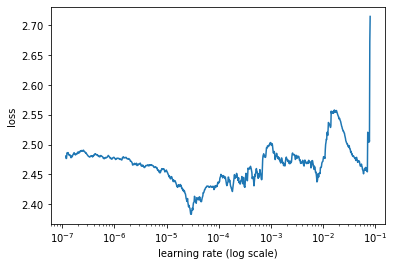

In [0]:
# Finding Optimal Learning Rate
distilbert_learner.lr_find(show_plot=True, max_epochs=2)

In [0]:
# Training the DistilBERT Model
distilbert_learner.autofit(4e-5)

early_stopping automatically enabled at patience=5
reduce_on_plateau automatically enabled at patience=2


begin training using triangular learning rate policy with max lr of 4e-05...
Train for 600 steps, validate for 38 steps
Epoch 1/1024
600/600 [==============================] - 150s 250ms/step - loss: 2.3095 - accuracy: 0.1881 - val_loss: 2.2176 - val_accuracy: 0.2417
Epoch 2/1024
600/600 [==============================] - 146s 243ms/step - loss: 2.1021 - accuracy: 0.2633 - val_loss: 2.0056 - val_accuracy: 0.3025
Epoch 3/1024
600/600 [==============================] - 146s 243ms/step - loss: 1.9478 - accuracy: 0.3267 - val_loss: 1.9096 - val_accuracy: 0.3692
Epoch 4/1024
600/600 [==============================] - 146s 243ms/step - loss: 1.7412 - accuracy: 0.4247 - val_loss: 1.8147 - val_accuracy: 0.4092
Epoch 5/1024
600/600 [==============================] - 146s 243ms/step - loss: 1.4565 - accuracy: 0.5142 - val_loss: 1.7852 - val_accuracy: 0.4250
Epoch 6/1024
600/600 [===========

In [0]:
# Save the Model
distilbert_learner.save_model('/content/drive/My Drive/Models')

In [0]:
# Preprocessing test data into DistilBERT format
b_test = b_t.preprocess_test(x_test, y_test)

preprocessing test...
language: en
test sequence lengths:
	mean : 65
	95percentile : 257
	99percentile : 907


In [0]:
# Validating performance of DistilBERT model
distilbert_learner.validate(val_data=test, class_names=flairs)

                    precision    recall  f1-score   support

            Sports       0.49      0.71      0.58       147
Science/Technology       0.47      0.33      0.39       115
          Politics       0.81      0.88      0.85        25
     Non-Political       0.85      0.96      0.90        46
          AskIndia       0.25      0.31      0.27        95
  Business/Finance       0.16      0.17      0.16       135
    Policy/Economy       0.55      0.43      0.48       101
         Scheduled       0.20      0.23      0.21        94
       Coronavirus       0.42      0.32      0.37       148
       Photography       0.83      0.65      0.73       107
       CAA-NRC-NPR       0.21      0.16      0.18        98
              Food       0.38      0.43      0.40        89

          accuracy                           0.41      1200
         macro avg       0.47      0.47      0.46      1200
      weighted avg       0.43      0.41      0.41      1200



array([[105,   4,   0,   0,  11,   8,   3,   4,   2,   1,   7,   2],
       [  6,  38,   0,   0,  15,  19,   3,  14,  11,   0,   2,   7],
       [  1,   0,  22,   0,   0,   0,   0,   0,   1,   1,   0,   0],
       [  0,   1,   0,  44,   0,   0,   0,   0,   0,   0,   1,   0],
       [ 24,   3,   0,   4,  29,   9,   1,   5,   2,   3,   6,   9],
       [ 21,   3,   1,   0,  19,  23,   7,  25,  12,   2,  12,  10],
       [ 10,   7,   0,   0,   7,   9,  43,   6,   0,   6,   7,   6],
       [  2,   4,   1,   0,   6,  18,   2,  22,  25,   1,   5,   8],
       [ 11,   7,   2,   2,  11,  21,   6,  17,  48,   0,   9,  14],
       [ 11,   3,   0,   0,   3,   5,   3,   2,   6,  70,   1,   3],
       [ 14,   8,   0,   1,  13,  23,   6,  12,   2,   0,  16,   3],
       [  9,   2,   1,   1,   2,  13,   4,   4,   6,   0,   9,  38]])